In [17]:
# Add project src to path.
import set_path

# Import modules.
import numpy as np
import time
import logging
from tqdm import tqdm

# Visulatisation
%matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils
import src.utils.math_utils as math_utils

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv
import pyransac3d as pyrsc

import open3d as o3d
from shapely.geometry import LineString
import shapely 
from scipy.optimize import curve_fit
import scipy.spatial

from multiprocessing import Pool
import pca
import RANSAC
from sklearn.cluster import DBSCAN

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks

#### Load Data

In [20]:
# Load data.
tilecode = '2387_9700'

# Labelled LAS file (see Notebook 0).
las_file = '../datasets/Valeriusplein/pointcloud/processed_' + tilecode + '.laz'
reduced_las_file = '../datasets/Valeriusplein/pointcloud/reduced_' + tilecode + '.laz'

# AHN data folder.
ahn_data_folder = '../datasets/Valeriusplein/ahn/'
# File with BGT building polygons.
bgt_building_file = '../datasets/Valeriusplein/bgt/bgt_buildings.csv'
# File with BGT road polygons.
bgt_road_file = '../datasets/Valeriusplein/bgt/bgt_roads.csv'
# File with <x,y> coordinates of pole-like objects.
bgt_pole_file = '../datasets/Valeriusplein/bgt/custom_poles.csv'
# File with <x,y> coordinates of street furniture objects.
bgt_street_furniture_file = '../datasets/Valeriusplein/bgt/bgt_street_furniture.csv'

# AHNReader for elevation data.
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

In [21]:
plot_utils.plot_bgt(tilecode, bgt_building_file, bgt_road_file, bgt_pole_file, bgt_street_furniture_file, padding=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Cable Extraction: Feature-based

In [22]:
# true pointcloud
labeled_pointcloud = las_utils.read_las(las_file)
true_labels = labeled_pointcloud.label

# reduced pointcloud
pointcloud = las_utils.read_las(reduced_las_file)
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = pointcloud.label

# mask for unlabelled
mask = np.where(labels == 0)[0]
mask_unlabelled = labels == 0

# Remove "noise filter"
mask_noise = labels == 99
mask = mask_noise | mask_unlabelled

In [23]:
true_cable_mask = (true_labels == 12) | (true_labels == 13) | (true_labels == 15)

#### Pipeline

In [24]:
# 1. Candidata cable point selection
cable_mask = candidate_cable_points(points, mask, 'radius')

# 2. Cluster candidate cable points
cable_mask,  clustering_labels_ = cluster_cable_points(points[mask], cable_mask)

# 3. Grow cable clusters
_, clustering_labels_ = grow_clusters(points[mask], clustering_labels_, section_length=3, grow_length=1, cable_with=0.1)

# 4. Merge cable clusters
clustering_labels_ = merge_clusters(points[mask], clustering_labels_)

/Users/user/Documents/CTO-Internship/Urban_PointCloud_Processing/.point_cloud/lib/python3.9/site-packages/pyransac3d/line.py:47: RuntimeWarning: invalid value encountered in true_divide
  vecA_norm = vecA / np.linalg.norm(vecA)
/var/folders/1p/z114bvjj7r59fvq3rbdcg3c40000gn/T/ipykernel_4793/2858840857.py:3: RuntimeWarning: invalid value encountered in true_divide
  return v1 / np.linalg.norm(v1)


In [25]:
score = mask_score(clustering_labels_ != 0, true_cable_mask[mask])
print(f'ACC: {round(score,2)}%')

ACC: 99.19%


In [26]:
score_plot(points, mask, clustering_labels_ != 0, true_cable_mask[mask])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [64]:
# score_plot(points, mask, clustering_labels_ != 0, true_cable_mask[mask])
# plot_clusters(points[mask], clustering_labels_, (0,), False)

In [27]:
cable_ids = np.where(mask)[0][np.where(clustering_labels_ != 0)[0]]
labels[cable_ids] = 11
out_file = '../datasets/Valeriusplein/pointcloud/M2_' + tilecode + '.laz'
las_utils.label_and_save_las(pointcloud, labels, out_file)

#### Step 1: Neighborhood Selection
Define the neighborhood of a point. Points will be used to calculate point features. (method: voxelization / distance-based / k-NN )

In [2]:
# Voxelization
def voxelize(points, mask, voxel_size, return_voxel_points=False, logger=False):
    """ Returns the voxelization of a Point Cloud."""

    # Voxelize point cloud
    cloud = PyntCloud(pd.DataFrame(points[mask,:], columns=['x','y','z']))
    voxelgrid_id = cloud.add_structure("voxelgrid", size_x=voxel_size, size_y=voxel_size, size_z=voxel_size, regular_bounding_box=False)
    voxel_grid = cloud.structures[voxelgrid_id]
    if logger:
        print('Voxels per axis:',voxel_grid.x_y_z)
        print('Voxel size:',voxel_grid.shape)

    # Group points per voxel 
    if return_voxel_points:
        pv_table = np.vstack([voxel_grid.voxel_n, np.arange(0,voxel_grid.voxel_n.shape[0])]).T
        pv_table = pv_table[pv_table[:, 0].argsort()]
        voxel_idx, voxel_idx_index = np.unique(pv_table[:, 0], return_index=True)
        voxel_points = np.split(pv_table[:, 1], voxel_idx_index[1:])

        return voxel_grid, voxel_points, voxel_idx
    
    return voxel_grid

def multi_proc_eig(covariances):
    """ Returns the eigendecomposition of `covariances`"""
    # Alternative: tqdm process_map(np.linalg.eig, covariances)
    with Pool() as pool:
        return pool.map(pca.eig, covariances)

def neighborhood_pca(points, mask, method='radius', knn=30, radius=1, voxel_size=1):
    """
    Returns the eigen values and vectors of points in a Point Cloud.
    
    Parameters
    ----------
    `points` : array of shape `(n_points, 3)`
        The point cloud <x, y, z>.
    `mask` : array of shape `(n_points,)` with `dtype=bool`
        Pre-mask used to label only a subset of the points.
    `method` : str
        The method to use to define a points neighborhood.
    `knn` : int (default= 30)
        k Nearest Neighbors parameter.
    `radius` : int (default= 1)
        Radius parameter.
    `voxel_size` : int (default= 1)
        voxelization parameter.

    Returns
    -------
    An array of shape (n_points, 2) indicating eigen values and vectors
    """

    #TODO: pyntcloud --> eigenvalues sneller?

    if method == 'knn':
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[mask])
        pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn))
        covariances = np.asarray(pcd.covariances)
        eig_val_vec = multi_proc_eig(covariances)

    elif method == 'radius':
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[mask])
        pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamRadius(radius=radius))
        covariances = np.asarray(pcd.covariances)
        eig_val_vec = multi_proc_eig(covariances)

    elif method == 'voxel':
        voxel_grid, voxel_point_idx, voxel_idx = voxelize(points, mask, voxel_size=voxel_size, return_voxel_points=True)
        voxel_table = {k: v for v, k in enumerate(voxel_idx)}
        covariances = [np.cov(points[mask][idx], rowvar=False) for idx in voxel_point_idx]
        voxel_eig_val_vec = multi_proc_eig(covariances)
        eig_val_vec = [voxel_eig_val_vec[voxel_table[voxel_id]] for voxel_id in voxel_grid.voxel_n]
    
    return eig_val_vec

#### Step 2: Cadidate Cable Points
Use PCA to calculate geometrical features of a point and assess linearity.

In [3]:
def candidate_cable_points(points, mask, method, eps_1=0.001, eps_2=0.1):

    eig_val_vec = neighborhood_pca(points, mask, method)

    assert len(eig_val_vec) == len(points[mask])

    # TODO: 
    # + New linearty formula
    # + Other geometric shapes (Planar & Volumetric)

    candidate_mask = np.zeros(len(points[mask]), dtype=bool)
    for i in range(len(eig_val_vec)):
        eig_val = eig_val_vec[i][0]
        if eig_val is not None:

            # Sort eigenvalues λ1 > λ2 > λ3
            idx = eig_val.argsort()[::-1]   
            eig_val = eig_val[idx]

            # Linearity Check
            if (abs(eig_val[1]-eig_val[2]) < eps_1) and eig_val[0] > eig_val[1] + eps_2:
                candidate_mask[i] = True

    return candidate_mask

##### Labelled cable PCA Analysis

In [20]:
def pca_method_comp(eig_val_vec, true_labels, mask, plotting=False):
    cable_idx = np.where(true_labels[mask]==11)[0]

    results_cable = []
    results_non_cable = []
    for i in range(len(eig_val_vec)):
        eig_val = eig_val_vec[i][0]
        if eig_val is not None:
            idx = eig_val.argsort()[::-1]   
            eig_val = eig_val[idx]
            if i in cable_idx:
                results_cable.append([round(eig_val[0],4),round(abs(eig_val[0]-eig_val[1]),4),round(abs(eig_val[1]-eig_val[2]),4)])
            else:
                results_non_cable.append([round(eig_val[0],4),round(abs(eig_val[0]-eig_val[1]),4),round(abs(eig_val[1]-eig_val[2]),4)])
        else:
            if i in cable_idx:
                results_cable.append([np.nan,np.nan,np.nan])
            else:
                results_non_cable.append([np.nan,np.nan,np.nan])

    df_results_cable = pd.DataFrame(results_cable, columns=['λ1','λ1-λ2','λ2-λ3'])
    df_results_non_cable = pd.DataFrame(results_non_cable, columns=['λ1','λ1-λ2','λ2-λ3'])
    df_results_non_cable = df_results_non_cable[df_results_non_cable['λ1'] < 1]

    if plotting:
        fig, ax = plt.subplots(1)
        df_results_cable.plot.scatter(x='λ1-λ2', y='λ2-λ3', s=0.1, alpha=0.5, ax=ax)
        df_results_non_cable.plot.scatter(x='λ1-λ2', y='λ2-λ3', c='r', s=0.1, alpha=0.5, ax=ax)

    return df_results_cable, df_results_non_cable

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

eig_val_vec = pc_pca(points, mask, method='radius', voxel_size=1.5)
df_a, df_b = pca_method_comp(eig_val_vec, true_labels, mask)

# Logistic Regregession Guess
x_a = df_a.dropna().values[:,1:]
x_b = df_b.dropna().values[:,1:]
X = np.vstack([x_a,x_b])
y = np.ones(len(X))
y[len(x_a):] = 0

clf = LogisticRegression(random_state=0).fit(X, y)
cable_gueses = np.where(clf.predict(X)==1)[0]
np.sum(y[cable_gueses]==1)/len(cable_gueses), np.sum(y[cable_gueses]==1), np.sum(y==1)

b = clf.intercept_[0]
w1, w2 = clf.coef_.T

c = -b/w2
m = -w1/w2

xmin, xmax = -0.01, 0.6
ymin, ymax = -0.01, 0.3
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X[:len(x_a)].T, s=4, alpha=0.5)
plt.scatter(*X[len(x_a):].T, s=4, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$λ_2-λ_3$')
plt.xlabel(r'$λ_1-λ_2$')

plt.show()


In [ ]:
def comparison_analysis(points, mask, method, radius=1, knn=30, voxel_size=1):

    eig_val_vec = pc_pca(points, mask, method=method, radius=radius, knn=knn, voxel_size=voxel_size)
    df_a, df_b = pca_method_comp(eig_val_vec, true_labels, mask)

    # Logistic Regregession Guess
    x_a = df_a.values[:,1:]
    x_b = df_b.values[:,1:]
    X = np.vstack([x_a,x_b])
    y = np.ones(len(X))
    y[len(x_a):] = 0

    scores = []
    for x1 in np.arange(0.1,0.3,0.01):
        for x2 in np.arange(0.0006,0.0024,0.0002):
            cable_gueses = np.where((X[:,0] > x1) & (X[:,1] < x2))[0]
            if len(cable_gueses) > 0:
                score = round(np.sum(y[cable_gueses]==1)/len(cable_gueses),2)
                qt = np.sum(y[cable_gueses]==1)
                scores.append([x1,x2,score,qt])

    df = pd.DataFrame(scores, columns=['x1','x2','acc','qty'])
    return df[df.qty>3000].sort_values(['acc','qty'], ascending=False)[:10], X, y


In [ ]:
for r in [1]:
    start=time.time()
    results = comparison_analysis(points, mask, method='radius', radius=r)[0]
    duration=time.time()-start
    print(f'Method RADIUS with r={r} ({round(duration,2)}s)')
    display(results)


In [ ]:
_, X, y = comparison_analysis(points, mask, method='radius', radius=1)
xmin = 0.1
ymax = 0.001

# to pts
cable_idx = np.where(true_labels[mask]==11)[0]
non_cable_idx = np.where(true_labels[mask]!=11)[0]

cable_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] > xmin) & (X[:len(cable_idx),1] < ymax))[0]]]
cable_n_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] <= xmin) | (X[:len(cable_idx),1] >= ymax))[0]]]
n_cable_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] > xmin) & (X[len(cable_idx):,1] < ymax))[0]]]
#n_cable_n_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] <= xmin) | (X[len(cable_idx):,1] >= ymax))[0]]]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(cable_lin[:, 0], cable_lin[:, 1], cable_lin[:, 2], s=2, color='tab:red', label='Cable (Linear)')
ax.scatter(cable_n_lin[:, 0], cable_n_lin[:, 1], cable_n_lin[:, 2], s=0.25, color='tab:green', alpha=0.25, label='Cable (Non-Linear)')
ax.scatter(n_cable_lin[:, 0], n_cable_lin[:, 1], n_cable_lin[:, 2], s=1, color='tab:blue', label='Non Cable (Linear)')
ax.set_zlim((0,12))
plt.legend()
plt.show()

In [ ]:
X, y = comparison_analysis(points, mask, method='radius', radius=1.5)
xmin = 0.21
ymax = 0.0008

# to pts
cable_idx = np.where(true_labels[mask]==11)[0]
non_cable_idx = np.where(true_labels[mask]!=11)[0]

cable_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] > xmin) & (X[:len(cable_idx),1] < ymax))[0]]]
cable_n_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] <= xmin) | (X[:len(cable_idx),1] >= ymax))[0]]]
n_cable_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] > xmin) & (X[len(cable_idx):,1] < ymax))[0]]]
n_cable_n_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] <= xmin) | (X[len(cable_idx):,1] >= ymax))[0]]]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(cable_lin[:, 0], cable_lin[:, 1], cable_lin[:, 2], s=1, color='tab:blue', label='Cable (Linear)')
ax.scatter(cable_n_lin[:, 0], cable_n_lin[:, 1], cable_n_lin[:, 2], s=0.5, color='tab:grey', alpha=0.5, label='Cable (Non-Linear)')
ax.scatter(n_cable_lin[:, 0], n_cable_lin[:, 1], n_cable_lin[:, 2], s=1, color='tab:red', label='Non Cable (Linear)')

ax.set_zlim((0,12))
plt.legend()
plt.show()

#### Step 3: Cluster Cable Points
Use euclidean distance clustering to cluster candidate cable points. (params: distance threshold)

In [4]:
def plot_clusters(points, clusters_labels, exclude_clusters=(), plot_3d=True):
    clusters = set(clusters_labels).difference(exclude_clusters)
    fig = plt.figure()

    if plot_3d:
        ax = plt.axes(projection='3d')
        for cluster in clusters:
            c_mask = clusters_labels == cluster
            ax.scatter(points[c_mask][:,0],points[c_mask][:,1],points[c_mask][:,2], s=2, label=str(cluster))
    else:
        ax = plt.axes()
        for cluster in clusters:
            c_mask = clusters_labels == cluster
            ax.scatter(points[c_mask][:,0],points[c_mask][:,1], s=1,label=str(cluster))
            
    plt.show()

In [5]:
def cluster_cable_points(points, cable_mask, min_points = 4):

    # Cluster the potential seed points.
    clustering = (DBSCAN(eps=.75, min_samples=4, p=2).fit(points[cable_mask]))
    cluster_labels, counts = np.unique(clustering.labels_, return_counts=True) # Get cluster labels and sizes.
    
    if min_points > 1:
        # Only keep clusters with size at least min_points.
        cluster_labels = cluster_labels[counts >= min_points]

    # Create cable cluster labels
    clustering_labels_ = np.zeros(len(cable_mask))
    cluster_name = 1
    cable_ids = np.where(cable_mask)[0]
    for cl in set(cluster_labels).difference((-1,)):
        c_mask = clustering.labels_ == cl
        clustering_labels_[cable_ids[c_mask]] = cluster_name
        cluster_name += 1

    # Update cable mask
    cable_mask = (clustering_labels_ != 0) 


    return cable_mask, clustering_labels_

In [6]:
def unit_vector(v1):
    """ Returns the unit vector of `v1`"""
    return v1 / np.linalg.norm(v1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def main_direction(points):
    """ Returns the eigenvector corresponding to the largest eigenvalue of `points`"""
    cov = np.cov(points, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    dir_v = eig_vec[:,eig_val.argmax()]
    if dir_v[0] < 0:
        dir_v *= -1
    return dir_v

def calc_cluster_properties(points, clustering_labels_, exclude_clusters=()):
    """ Returns a dict with cluster properties"""

    properties = {}
    for cl in set(clustering_labels_).difference(exclude_clusters):
        cl_points = points[clustering_labels_ == cl]

        cluster_property = {
            'z_mean': np.mean(cl_points[:,2]),
            'z_min': np.min(cl_points[:,2]),
            'z_max': np.max(cl_points[:,2]),
            'eig_v': main_direction(cl_points),
            'line_fit': pyrsc.Line().fit(cl_points, thresh=0.2, maxIteration=100)[:2],
            'plane_fit': RANSAC.Line().fit(cl_points, residual_threshold=0.2, max_trials=100)[0]
            }
        
        properties[cl] = cluster_property
    return properties

### Step: Cable Growing

In [13]:
# np.save('points.npy', points)
# np.save('mask.npy', mask)
# np.save('cl_labels.npy', clustering_labels_)

# points = np.load('points.npy')
# mask = np.load('mask.npy')
# clustering_labels_ = np.load('cl_labels.npy')

In [7]:
def grow_section(section_points, unlabeled_points, res_threshold=0.1):

    # least-square curve fit
    X_in = section_points[:,0]
    A = np.c_[X_in, X_in*X_in, np.ones(len(X_in))]
    C = np.linalg.lstsq(A, section_points[:,1], rcond=None)[0]

    # Distance from unlabeled points to fitted curve
    X_out = unlabeled_points[:,0]
    Z_points = np.dot(np.c_[X_out, X_out*X_out, np.ones(len(X_out))], C)
    residuals = Z_points - unlabeled_points[:,1]
    inlier_mask = np.abs(residuals) < res_threshold

    return inlier_mask

def grow_clusters(points, cluster_labels, exclude_clusters=(0,), section_length=3, grow_length=1, cable_with=0.1):
    
    labels = cluster_labels.copy()
    labels_mask = np.zeros(len(labels), dtype=bool)

    for cl in set(labels).difference(exclude_clusters):
        cl_mask = labels == cl
        cl_points = points[cl_mask]
        unlabeled_ids = np.where(labels == 0)[0]

        # Create directional Axis
        cl_dir = main_direction(cl_points[:,:2])
        cl_D = np.dot(cl_points[:,:2], cl_dir)
        cl_length = cl_D.max() - cl_D.min()
        if cl_length > 1:
            cl_points_dir = np.vstack([cl_D, cl_points[:,2]]).T
            dxy_v = unit_vector(cl_dir) * grow_length

            # grow head-section
            head_ids = cl_D > cl_D.max() - section_length
            head_xy = cl_points[cl_D.argmax(),:2]
            grow_area = LineString([head_xy,head_xy + dxy_v]).buffer(cable_with)
            grow_area_mask = clip_utils.poly_clip(points[unlabeled_ids], grow_area)
            grow_ids = unlabeled_ids[grow_area_mask]
            grow_points_D = np.vstack([np.dot(points[grow_ids][:,:2], cl_dir), points[grow_ids][:,2]]).T
            inlier_mask = grow_section(cl_points_dir[head_ids], grow_points_D, cable_with)
            labels[grow_ids[inlier_mask]] = cl
            labels_mask[grow_ids[inlier_mask]] = True

            # Grow tail-section
            tail_ids = cl_D < cl_D.min() + section_length
            tail_xy = cl_points[cl_D.argmin(),:2]
            grow_area = LineString([tail_xy,tail_xy - dxy_v]).buffer(cable_with)
            grow_area_mask = clip_utils.poly_clip(points[unlabeled_ids], grow_area)
            grow_ids = unlabeled_ids[grow_area_mask]
            grow_points_D = np.vstack([np.dot(points[grow_ids][:,:2], cl_dir), points[grow_ids][:,2]]).T
            inlier_mask = grow_section(cl_points_dir[tail_ids], grow_points_D, cable_with)
            labels[grow_ids[inlier_mask]] = cl
            labels_mask[grow_ids[inlier_mask]] = True

    return labels_mask, labels

In [8]:
def mask_score(predicted, true):
    score = 100 * np.sum(np.logical_and(predicted, true)) / np.sum(true)
    return score

def score_plot(points, mask, predicted, true):

    true_ids = set(np.where(predicted)[0])
    predicted_ids = set(np.where(true)[0])

    TP = list(true_ids.intersection(predicted_ids))
    FP = list(predicted_ids.difference(true_ids))
    FN = list(true_ids.difference(predicted_ids))

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter(points[mask][TP][:,0], points[mask][TP][:,1], points[mask][TP][:,2], s=1, alpha=0.5, color='green')
    ax.scatter(points[mask][FP][:,0], points[mask][FP][:,1], points[mask][FP][:,2], s=1, color='red')
    ax.scatter(points[mask][FN][:,0], points[mask][FN][:,1], points[mask][FN][:,2], s=1, alpha=0.8, color='grey')
    ax.set_zlim((0,15))

ACC: 96.11% (82.96% before)


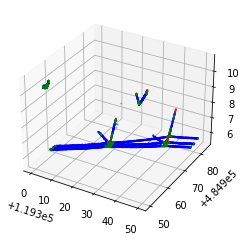

In [15]:
# Grow cable clusters
labels_mask, clustering_labels_ = grow_clusters(points[mask], clustering_labels_, section_length=3, grow_length=1, cable_with=0.1)

score = mask_score((clustering_labels_ != 0), true_cable_mask[mask])
print(f'ACC: {round(score,2)}%')

score_plot(points, mask, (clustering_labels_ != 0), true_cable_mask[mask])
plot_clusters(points[mask], clustering_labels_, (0,), False)

### Step 4: Merge cable segments
Use cable segment properties to determine if cable segments belong to the same cable. Features which can be used: direction, height, and catenary fit.

In [9]:
def catenary_func(x, a, b, c):
    return a + c * np.cosh((x-b) / c)

def nearest_points(pts_a, pts_b):
    cdist = scipy.spatial.distance.cdist(pts_a, pts_b)
    idx_a, idx_b = np.unravel_index(np.argmin(cdist), cdist.shape)
    return pts_a[idx_a], pts_b[idx_b], cdist.min()

def catenary_merge(points, mask_A, mask_B, mask_unlabelled, plot=False):

    # Define points
    pts_A = points[mask_A]
    pts_B = points[mask_B]
    pts = np.vstack([pts_A, pts_B])
    cable_dir = main_direction(pts[:,:2])
    
    # Define search gap
    pA, pB, _ = nearest_points(pts_A, pts_B)
    merge_line = LineString([pA, pB])
    fit_mask = clip_utils.poly_clip(pts, merge_line.buffer(2.5))

    # Trim cable points
    d_pts = np.dot(pts[fit_mask][:,:2], cable_dir)
    d_shift = d_pts.min()
    d_pts -= d_shift
    z_pts = pts[fit_mask][:,2]

    # Gap points
    gap_mask = clip_utils.poly_box_clip(points[mask_unlabelled], merge_line.buffer(.1), bottom=z_pts.min(), top=z_pts.max())
    gap_pts = points[mask_unlabelled][gap_mask]
    d_gap_pts = np.dot(gap_pts[:,:2], cable_dir) - d_shift
    z_gap_pts = gap_pts[:,2]

    # Curve fit on cable segments
    popt, _ = curve_fit(catenary_func, d_pts, z_pts)

    # Evaluate fit on cable
    dist_z = abs(catenary_func(d_pts, *popt) - z_pts)
    fit_inliers = dist_z < 0.1
    fit_score = np.sum(fit_inliers) / len(fit_inliers)

    # Evaluate fit on gap
    dist_gap_z = abs(catenary_func(d_gap_pts, *popt) - z_gap_pts)
    gap_inliers = dist_gap_z < 0.1
    gap_score = np.sum(gap_inliers) / len(gap_pts)

    if plot:
        x = np.linspace(d_pts.min(),d_pts.max(),100)
        y = catenary_func(x, *popt)

        fig = plt.figure()
        ax = plt.axes()
        ax.scatter(d_pts[fit_inliers], z_pts[fit_inliers], s=1, color='blue')
        ax.scatter(d_pts[~fit_inliers], z_pts[~fit_inliers], s=1, color='grey')
        ax.scatter(d_gap_pts[gap_inliers], z_gap_pts[gap_inliers], s=1, color='green')
        ax.scatter(d_gap_pts[~gap_inliers], z_gap_pts[~gap_inliers], s=1, color='red')
        ax.plot(x, y, color='k', linestyle='--', linewidth=1)
        ax.set_ylim((4,10))

    inliers_mask = np.where(gap_mask)[0][gap_inliers]

    return fit_score, gap_score, inliers_mask

def end_points(pts_a):
    dir = main_direction(pts_a[:,:2])
    d_pts = np.dot(pts_a[:,:2], dir)
    idx_a, idx_b = d_pts.argmin(), d_pts.argmax()
    return pts_a[idx_a], pts_a[idx_b]

def merge_clusters(points, clustering_labels_, max_angle_A=45, max_dist_A=.5, max_angle_B=5, max_dist_B=5):

    cluster_labels, counts = np.unique(clustering_labels_, return_counts=True)
    cluster_labels_sorted = list(cluster_labels[1:][counts[1:].argsort()[::-1]])

    while len(cluster_labels_sorted) > 0:
        current_label = cluster_labels_sorted[0]
        candidate_labels = cluster_labels_sorted[1:]

        for candidate_label in candidate_labels:

            # TODO: pyrsc.Line().fit --> normal direction analysis? or faster

            # Define current cluster
            maskCur = clustering_labels_ == current_label
            current_pts = points[maskCur]
            endpts_can = end_points(current_pts)
            current_v, current_i = pyrsc.Line().fit(current_pts, thresh=0.2, maxIteration=100)[:2]

            # Define candidate cluster
            maskCan = clustering_labels_ == candidate_label
            candidate_pts = points[maskCan]
            endpts_cur = end_points(candidate_pts)
            candidate_v = pyrsc.Line().fit(candidate_pts, thresh=0.2, maxIteration=100)[0]

            # Define unlabeled
            mask_unlabelled = clustering_labels_ == 0

            # Order endpoints of clusters in line
            line_distances = scipy.spatial.distance.cdist(endpts_cur,endpts_can)
            idx_cur, idx_can = np.unravel_index(line_distances.argmin(), line_distances.shape)
            p1_cur, p2_cur = endpts_cur[idx_cur], endpts_cur[1-idx_cur]
            p1_can, p2_can = endpts_can[idx_can], endpts_can[1-idx_can]
            merge_line = LineString([p1_cur,p1_can])
            merge_dist = np.min(line_distances)

            # Merge properties
            merge_angle = angle_between((p2_cur - p1_cur)[:2], (p1_can - p1_cur)[:2])
            dir_angle = angle_between(candidate_v[:2], current_v[:2])
            # print(candidate_label, 'to',current_label, ':', (round(merge_angle,2),(180 - max_angle_A)), round(dir_angle,2), (round(merge_dist,2),max_dist_A))
            
            if merge_angle > 90 and (dir_angle < max_angle_A or dir_angle > 180-max_angle_A) and merge_dist < max_dist_A:  
                # 1. Clusters nearby
                clustering_labels_[maskCan] = current_label
                cluster_labels_sorted.remove(candidate_label)
                fill_mask = clip_utils.poly_box_clip(points[mask_unlabelled], merge_line.buffer(.1), bottom=np.min([p1_cur[2],p1_can[2]]), top=np.max([p1_cur[2],p1_can[2]]))
                clustering_labels_[mask_unlabelled][fill_mask] = current_label
                # print('Added cluster', candidate_label, 'to',current_label)

            elif merge_angle > (180 - max_angle_B) and (dir_angle < max_angle_A or dir_angle > 180-max_angle_A) and merge_dist < max_dist_B: 
                # 2. Cluster far away
                fit_score, gap_score, gap_inliers = catenary_merge(points, maskCan, maskCur, mask_unlabelled, False)
                if fit_score > .8:
                    clustering_labels_[maskCan] = current_label
                    cluster_labels_sorted.remove(candidate_label)
                    clustering_labels_[np.where(mask_unlabelled)[0][gap_inliers]] = current_label
                    # print('Added cluster', candidate_label, 'to',current_label)

        # Remove cluster from list
        cluster_labels_sorted.remove(current_label)
    
    return clustering_labels_

/var/folders/17/htr55f_n3pz93x7x89m0_nlc0000gp/T/ipykernel_1249/2858840857.py:3: RuntimeWarning: invalid value encountered in true_divide
  return v1 / np.linalg.norm(v1)


ACC: 97.71% (96.11% before)


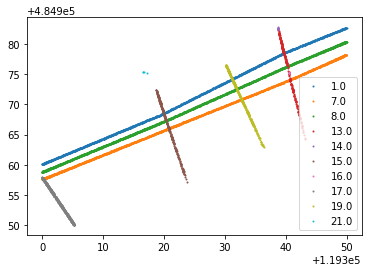

In [18]:
# Merge cable clusters
clustering_labels_ = merge_clusters(points[mask], clustering_labels_)
score = mask_score((clustering_labels_ != 0), true_cable_mask[mask])
print(f'ACC: {round(score,2)}%')

score_plot(points, mask, (clustering_labels_ != 0), true_cable_mask[mask])
plot_clusters(points[mask], clustering_labels_, (0,), False)

### export

In [67]:
cable_ids = np.where(mask)[0][np.where(clustering_labels_ != 0)[0]]
labels[cable_ids] = 11
out_file = '../datasets/Valeriusplein/pointcloud/M2_' + tilecode + '.laz'
las_utils.label_and_save_las(pointcloud, labels, out_file)

In [41]:
# # Analysis Export

# cable_point_ids = np.where(mask)[0][np.where(clustering_labels_ != 0)[0]]

# tp_ids = set(np.where(true_cable_mask)[0]).intersection(set(cable_point_ids))
# fn_ids = set(np.where(true_cable_mask)[0]).difference(set(cable_point_ids))
# fp_ids = set(cable_point_ids).difference(set(np.where(true_cable_mask)[0]))

# labels[list(tp_ids)] = 11
# labels[list(fp_ids)] = 16
# labels[list(fn_ids)] = 18
# print((labels==11).sum() )
# out_file = '../datasets/Valeriusplein/pointcloud/exp_B_' + tilecode + '.laz'
# las_utils.label_and_save_las(pointcloud, labels, out_file)

7419
